# Stacked Denoising Autoencoder (SDA)
Uses the Tensoflow machine learning library to train the Stacked Denoising Autoencoder (SDA) to reconstruct 
compressed 
***MNIST*** images with Poisson noise.

**Author:** Fabian Santiago  
**Update:** August 21, 2024

**Implementation:** SDA architecture discussed in:
**[IEEE publication](https://ieeexplore.ieee.org/abstract/document/8682767)**

# Import Modules and Libraries

In [1]:
from __future__ import division, print_function, absolute_import
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from skimage.util.shape import view_as_windows

2024-08-21 17:15:14.079129: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Set Values: Seed, Compression, and Output Dimension 

In [2]:
# Set the seed for TensorFlow and Keras
tf.random.set_seed(101)

# Dimension of the compressed/noisy images (width=height)  
# cmp_dim = 4:(for 4x4), 7:(7x7), 14:(14x14), or 28:(28x284)
cmp_dim = 7

# Dimension of output, original are 28 x 28
out_dim  = 28 

# Helper Function Definitions

In [3]:
# Define sliding window compression
def median_downsampling(in_image, cmp_dim):
    if cmp_dim < 15:
        # Compression dimension to window size
        window_size = 28//cmp_dim
        # Create sliding windows
        windows = view_as_windows(in_image, (window_size, window_size), step=window_size)
        # Calculate the median over each window
        return np.median(windows, axis=(2, 3))
    else:
        return in_image

# Define compression of entries in an array
def down_sample_list(in_array,cmp_dim):
    out_array = np.empty((len(in_array), cmp_dim, cmp_dim))
    
    # Iterate over array
    for idx, image in enumerate(in_array):
        out_array[idx] = median_downsampling(image,cmp_dim)
        
    # Return array containing compressed entries 
    return out_array 

# Split dataset into two
def split_dataset_rnd(in_images):

    # Total number of images
    num_images = in_images.shape[0]
    
    # Random permutation of indices
    shuffled_indices = np.random.permutation(num_images)
    
    # Calculate the split index
    split_index = num_images // 2
    
    # Split the shuffled indices
    idx1 = shuffled_indices[:split_index]
    idx2 = shuffled_indices[split_index:]
    
    # Use the indices to create two random datasets
    dat1 = in_images[idx1]
    dat2 = in_images[idx2]
    
    return dat1, dat2

# Create compressed noisy data
def create_training_test_data(clean_train, clean_test, cmp_dim, out_dim):
    
    # Step 0: Create Training and Validation Sets
    clean_test, clean_valid = split_dataset_rnd(clean_test)
    
    # Step 1: Compress images using median in sliding window
    cmp_train = down_sample_list(clean_train, cmp_dim)
    cmp_test  = down_sample_list(clean_test, cmp_dim)
    cmp_valid  = down_sample_list(clean_valid, cmp_dim)

    # Step 2: Add Poisson noise to compressed images
    noisy_train_ = np.random.poisson(lam=cmp_train)
    noisy_test_  = np.random.poisson(lam=cmp_test)
    noisy_valid_ = np.random.poisson(lam=cmp_valid)
    
    noisy_train  = np.clip(noisy_train_,0,255)
    noisy_test   = np.clip(noisy_test_,0,255)
    noisy_valid  = np.clip(noisy_valid_,0,255)
    
    # Step 3: Reshape Input Arrays and scale from [0, 255] to [0,1]
    noisy_train = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_train/255])
    noisy_test  = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_test/255])
    noisy_valid = np.array([matrix.reshape(cmp_dim**2,) for matrix in noisy_valid/255])
    
    # Step 4: Reshape Expected Ouput Arraus and scale from [0, 255] to [0,1]
    clean_train = np.array([matrix.reshape(out_dim**2,) for matrix in clean_train/255])
    clean_test  = np.array([matrix.reshape(out_dim**2,) for matrix in clean_test/255])
    clean_valid = np.array([matrix.reshape(out_dim**2,) for matrix in clean_valid/255])
    
    # Step 5: Return training data
    return [clean_train, clean_test, clean_valid, noisy_train, noisy_test, noisy_valid]

# Stacked Denoising Autoencoder (SDA) Builder
def build_SDA(in_dim, out_dim, noise_factor=0.2):
    model = models.Sequential()

    # Define the input layer
    model.add(layers.Input(shape=(in_dim**2,)))

    # Add noise to input using GaussianNoise layer to stimulate 
    # denoising, thereby ignoring small perturbations in input
    model.add(layers.GaussianNoise(noise_factor))

    # Encoder
    model.add(layers.Dense(in_dim**2, activation='sigmoid', kernel_initializer='he_normal'))

    # Add Gaussian noise after the encoder
    model.add(layers.GaussianNoise(noise_factor))

    # Decoder
    model.add(layers.Dense(out_dim**2, activation='sigmoid', kernel_initializer='he_normal'))

    return model

## Load/Create Training Data
Load traning data or load MNIST data and create training data if it has not already been created

In [4]:
directory = 'training_data'

# If the directory does not exist, create it
if not os.path.exists(directory):
    os.makedirs(directory)

# Load the MNIST Dataset
file = f'mnist_training_data_cmp' # Do not modify

# If the training data does not exist, create it
if not os.path.exists(f'{directory}/{file}.h5'):
    # Load MNIST
    (clean_train, _), (clean_test, _) = tf.keras.datasets.mnist.load_data()
    
    # Create compressed/noisy data, test set, and validation set
    train_data = create_training_test_data(clean_train, clean_test, cmp_dim, out_dim)
    
    # MNIST data
    clean_train = train_data[0]
    clean_test  = train_data[1]
    clean_valid = train_data[2]
    
    # Compressed noisy signals
    noisy_train = train_data[3]
    noisy_test  = train_data[4]
    noisy_valid = train_data[5]
    
    # Save with compression
    with h5py.File(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5', 'w') as f:
        # Save original images
        f.create_dataset('clean_train', data=clean_train, compression='gzip')
        f.create_dataset('clean_test', data=clean_test, compression='gzip')
        f.create_dataset('clean_valid', data=clean_valid, compression='gzip')
        
        # Save compressed noisy images
        f.create_dataset('noisy_train', data=noisy_train, compression='gzip')
        f.create_dataset('noisy_test', data=noisy_test, compression='gzip')
        f.create_dataset('noisy_valid', data=noisy_valid, compression='gzip')
        
else: # If data exists, load it
    with h5py.File(f'{directory}/{file}_{cmp_dim}x{cmp_dim}.h5', 'r') as dat_file:

        # Load original MNIST images
        clean_train = dat_file['clean_train'][:]
        clean_test  = dat_file['clean_test'][:]
        clean_valid = dat_file['clean_valid'][:]

        # Load compressed noisy images
        noisy_train = dat_file['noisy_train'][:]
        noisy_test  = dat_file['noisy_test'][:]
        noisy_valid = dat_file['noisy_valid'][:]

## Display Training Dataset Examples

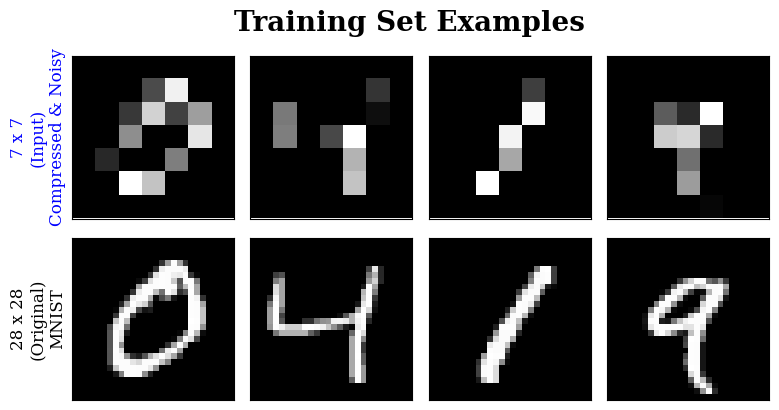

In [5]:
# Create a 2 by 4 subplot handle
fig, axes = plt.subplots(2, 4, figsize=(9, 4.5))
axes      = axes.flatten()

# Add title
fig.suptitle('Training Set Examples', fontsize=20, fontweight='bold', fontfamily='serif')

# Shift window through training dataset 
sft_idx = 1

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
#     axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot original
    axes[idx+4].imshow(clean_train[idx+sft_idx].reshape(out_dim,out_dim),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
# Set ylables 
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel('28 x 28\n(Original)\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)

# Display the figure
plt.show()

## Compile & Train Model

In [14]:
# Create the model
SDA = build_SDA(in_dim = cmp_dim, out_dim = out_dim)

# Create an RMSProp optimizer with a specific learning rate
RMSp = tf.keras.optimizers.RMSprop(learning_rate=0.05)

# Compile the model
SDA.compile(optimizer=RMSp, loss='mean_squared_error')

# Train model
fit_history = SDA.fit(noisy_train, clean_train, epochs=200, batch_size=250,validation_data=(noisy_test, clean_test))

Epoch 1/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0764 - val_loss: 0.0505
Epoch 2/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0518 - val_loss: 0.0429
Epoch 3/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0472 - val_loss: 0.0400
Epoch 4/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0454 - val_loss: 0.0385
Epoch 5/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0444 - val_loss: 0.0375
Epoch 6/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0437 - val_loss: 0.0368
Epoch 7/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0433 - val_loss: 0.0363
Epoch 8/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.0359
Epoch 9/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0426 - val_loss: 0.0355
Epoch 10/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0424 - val_loss: 0.0353
Epoch 11/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0421 - val_loss: 0.0351
Epoch 12/200
240/240 ━━━━━━━━━━━━━━━━━━━━

240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0400 - val_loss: 0.0331
Epoch 69/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0400 - val_loss: 0.0331
Epoch 70/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0400 - val_loss: 0.0332
Epoch 71/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 72/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 73/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 74/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0400 - val_loss: 0.0331
Epoch 75/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 76/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0330
Epoch 77/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 78/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0399 - val_loss: 0.0331
Epoch 79/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 

Epoch 135/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 136/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0397 - val_loss: 0.0329
Epoch 137/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0397 - val_loss: 0.0329
Epoch 138/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0397 - val_loss: 0.0329
Epoch 139/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 140/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 141/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 142/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 143/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 144/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 145/200
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - val_loss: 0.0329
Epoch 146/200
240/240

In [11]:
SDA.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gaussian_noise (GaussianNoise)  │ (None, 49)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 49)             │         2,450 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 49)             │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 784)            │        39,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,302 (325.40 KB)

 Trainable params: 41,650 (162.70 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,652 (162.71 KB)

## Apply SDA to Training Set and Display Output

In [12]:
# Apply SDA to all training inputs
pred_train_out = SDA.predict(noisy_train)

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 650us/step


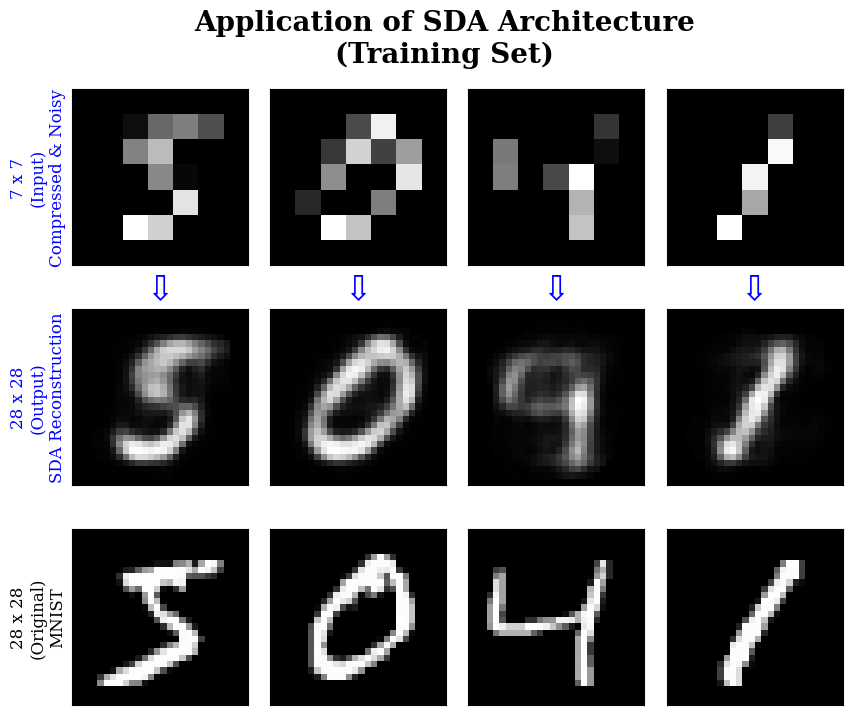

In [13]:
# Print examples: training set
################################

# Create a 3 by 4 subplot handle
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of SDA Architecture\n(Training Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift window through training dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_train[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot decompressed with SDA
    axes[idx+4].imshow(pred_train_out[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+8].imshow(clean_train[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
# Set ylables 
# axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Pre-Input)\nCompressed',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel('28 x 28\n(Output)\nSDA Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[8].set_ylabel('28 x 28\n(Original)\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.25)

# Display the figure
plt.show()

## Apply SDA to Validation Set and Display Example Output

In [9]:
pred_valid_out = SDA.predict(noisy_valid)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 683us/step


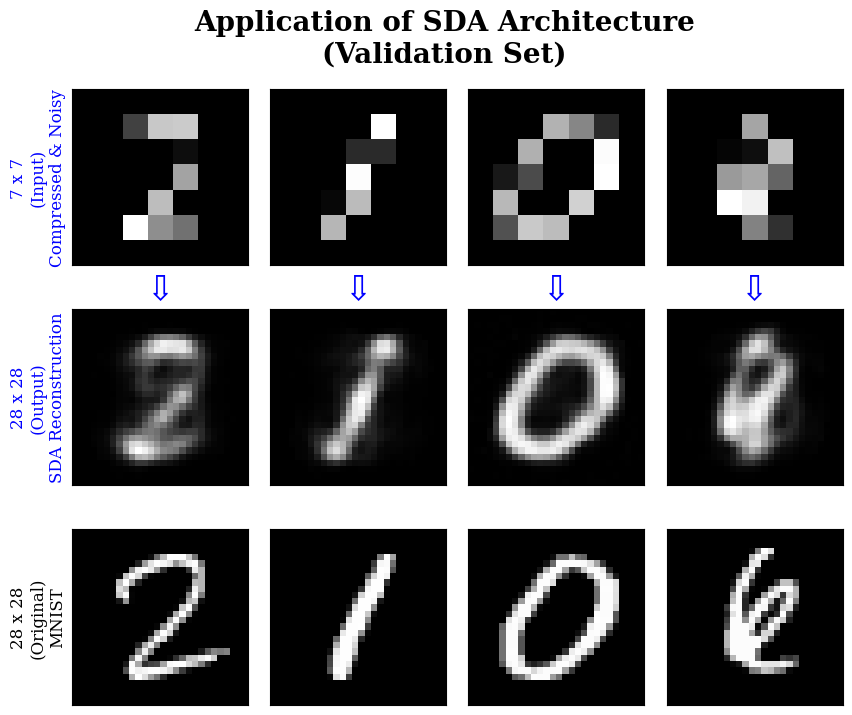

In [10]:
# Create a 3 by 4 subplot handle
fig, axes = plt.subplots(3, 4, figsize=(10, 8))
axes      = axes.flatten()

# Add title
fig.suptitle('Application of SDA Architecture\n(Validation Set)',fontsize=20,fontweight='bold', fontfamily='serif')

# Shift window through validation dataset 
sft_idx = 0

# Plot noisy and decompressed realizations in each subplot
for idx in range(4):
    # Plot noisy
    axes[idx].imshow(noisy_valid[idx+sft_idx].reshape(cmp_dim,cmp_dim),cmap='gray')
    axes[idx].set_xticks([]) # Remove xticklabels
    axes[idx].set_yticks([]) # Remove yticklabels
    axes[idx].set_xlabel('⇩',fontdict={'fontsize': 25, 'fontweight': 'bold', 'fontfamily': 'serif', 'color':'blue'})
    
    # Plot decompressed with SDA
    axes[idx+4].imshow(pred_valid_out[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+4].set_xticks([]) # Remove xticklabels
    axes[idx+4].set_yticks([]) # Remove yticklabels
    
    # Plot original
    axes[idx+8].imshow(clean_valid[idx+sft_idx].reshape(28,28),cmap='gray')
    axes[idx+8].set_xticks([]) # Remove xticklabels
    axes[idx+8].set_yticks([]) # Remove yticklabels
    
# Set ylables 
# axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Pre-Input)\nCompressed',fontdict={'fontsize': 12, 'fontfamily': 'serif'})
axes[0].set_ylabel(f'{cmp_dim} x {cmp_dim}\n(Input)\nCompressed & Noisy',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[4].set_ylabel('28 x 28\n(Output)\nSDA Reconstruction',fontdict={'fontsize': 12, 'fontfamily': 'serif', 'color':'blue'})
axes[8].set_ylabel('28 x 28\n(Original)\nMNIST',fontdict={'fontsize': 12, 'fontfamily': 'serif'})

# Adjust layout to decrease padding between subplots
plt.subplots_adjust(wspace=0.1, hspace=0.25)

# Display the figure
plt.show()